# Slow close-up

Although our playback speed is slow already (0.01X), the bouncing event still looks very fast. To be able to see the bouncing very clearly, it is desired that we do a slow close-up at the bouncing event, where fps is dramatically increased and the camera is moved close to the bubble.

In this notebook, we implement the functions necessary for this purpose. First, we implement a time mesh generator that can generate non-uniform time mesh according to a set of FPS keyframes. Then, we develop a `scene` class that simplifies the animation script.

## 0 Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import time
from scipy.interpolate import CubicSpline, interp1d
from bubble_bouncing import TimeMesh

## 1 Slow motion

We implement a `TimeMesh` class to interpolate keyframes in fps. Below, we test the class and meantime provide an example of usage. 

(np.float64(-0.0010005773878738313),
 np.float64(0.021012125145350457),
 np.float64(-0.05),
 np.float64(1.05))

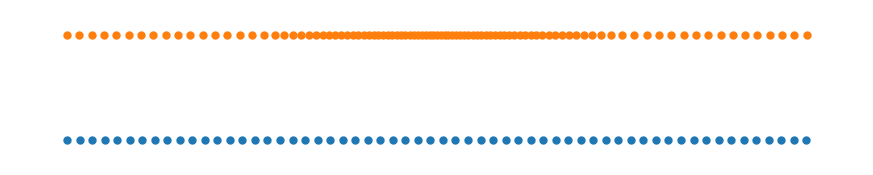

In [12]:
tm = TimeMesh(0, 0.02, 3000)
keyframes = [
    (0.005, 3000),
    (0.01, 10000),
    (0.015, 3000)]
tm.insert_keyframes(keyframes)
uniform = tm.uniform()
nonuniform = tm.generate(interpolate="linear")

plt.figure(figsize=(3.5, .5), dpi=300)
plt.plot(uniform, np.zeros_like(uniform), "o", markersize=1)
plt.plot(nonuniform, np.ones_like(nonuniform), "o", markersize=1)
plt.axis("off")

## 2 The `Scene` class

In [1]:
from bubble_bouncing import Scene, Bubble, TimeMesh
import numpy as np
import pyvista as pv
from pathlib import Path
import h5py
import yaml

In [2]:
scene = Scene()

In [3]:
folder = Path("/Users/zhengyang/Documents/.bcsim_test").expanduser().resolve()
h5file = folder / "results" / "data.h5"
params_file = folder / "params.yaml"

### 2.1 Moving sphere

In [4]:
data = {}
with h5py.File(h5file, "r") as f:
    for kw in ["t", "x"]:
        data[kw] = f[kw][:]
with open(params_file, "r") as f:
    params = yaml.safe_load(f)
sphere = scene.Sphere(data, radius=params["R"])

In [ ]:
scene.play(fps=30, playback=0.01, t_range=[0.0, 1])

Time is not set. Infer from actor data.


Animation complete (595/595)


### 2.2 Moving glyph

In [5]:
with h5py.File(h5file, "r") as f:
    t = f["t"][:]
    x_im = f["x_im"][:]
    V_im = f["V_im"][:]
    x_re = f["x"][:]
    V_re = f["V"][:]

In [6]:
x_list = []
v_list = []
im = Bubble(a=params["R"])
re = Bubble(a=params["R"])
for i in range(len(t)):
    im.set_pos(x_im[i])
    im.set_velocity(V_im[i])
    re.set_pos(x_re[i])
    re.set_velocity(V_re[i])
    x = re.pos+re.surf_coords
    v = im.Oseen_wake(x)
    x_list.append(x)
    v_list.append(v)

In [7]:
data = {"t": t, "x": np.stack(x_list), "v": np.stack(v_list)}
glyph = scene.Glyph(data, "flow")

In [9]:
scene.play(playback=0.01)

Animation complete (596/596).


### 2.3 Box: for the stationary surface 

In [8]:
xlim=(-4e-2, 4e-2)
ylim = (-1e-3, 0)
zlim = (-0.01, 0.01)
t = np.linspace(0, 1, 50)
x = np.zeros((50, 3))
surface = scene.Box({"t": t, "x": x}, bounds=(*xlim, *ylim, *zlim))

### 2.4 Set time sequence

In [9]:
with h5py.File(h5file, "r") as f:
    t = f["t"][:]
    x_im = f["x_im"][:]
t_bounce = t[np.isnan(x_im[:, 0]).argmin()]
tm = TimeMesh(t[0], t[-1], 3000)
window = 0.01
keyframes = [
    (t_bounce - window / 2, 3000),
    (t_bounce, 30000),
    (t_bounce + window / 2, 3000)
]
tm.insert_keyframes(keyframes)

In [10]:
t_ = tm.generate("linear")

In [11]:
scene.set_time(t_)

### 2.5 Camera motion

In [16]:
scene.camera_position = "yx"

In [17]:
theta_rad = params["theta"] / 180 * np.pi
up = np.array([np.sin(theta_rad), -np.cos(theta_rad), 0])

In [19]:
p = np.zeros((3, 3))
p[0, :] = scene.camera_position[0]
p[1, :] = scene.camera_position[1]
p[2, :] = up
scene.camera_position = p

In [15]:
scene.show_axes()

In [27]:
scene.play(playback=0.01)

In [20]:
cp_far = np.asarray(list(scene.camera_position))

In [21]:
cp_far

array([[-5.41173497e-06,  2.89114193e-04, -2.87610813e-02],
       [-5.41173497e-06,  2.89114193e-04,  0.00000000e+00],
       [ 1.74524064e-02, -9.99847695e-01,  0.00000000e+00]])

In [22]:
cp_close = np.asarray(list(scene.camera_position))

In [23]:
cp_close

array([[-5.41173497e-06,  2.89114193e-04, -1.10886419e-02],
       [-5.41173497e-06,  2.89114193e-04,  0.00000000e+00],
       [ 1.74524064e-02, -9.99847695e-01,  0.00000000e+00]])

In [39]:
keyframes = [
    (0, cp_far),
    (t_bounce - window / 2, cp_far),
    (t_bounce, cp_close),
    (t_bounce + window / 2, cp_far),
    (scene.t[-1], cp_far)
]

In [35]:
scene.set_camera_keyframes()

array([[ 0.00000000e+00,  7.39697485e-05, -3.46810739e-02],
       [ 0.00000000e+00,  7.39697485e-05,  0.00000000e+00],
       [ 1.74524064e-02, -9.99847695e-01,  0.00000000e+00]])

In [52]:
t = np.asarray([float(t_) for t_, _ in keyframes])
cp = np.stack([cp_ for _, cp_ in keyframes])

In [54]:
from scipy.interpolate import interp1d
f = interp1d(t, cp, axis=0)

### 2.6 All together

In [1]:
# from bubble_bouncing import Scene, Bubble, TimeMesh
from pyvid import Scene
import numpy as np
import pyvista as pv
from pathlib import Path
# import h5py
# import yaml

scene = Scene()

In [2]:
scene.clear_all()
folder = Path("/Users/zhengyang/Documents/.bcsim_test").expanduser().resolve()
h5file = folder / "results" / "data.h5"
params_file = folder / "params.yaml"

# add bubble
data = {}
with h5py.File(h5file, "r") as f:
    t = f["t"][:]
    x = f["x"][:]
with open(params_file, "r") as f:
    params = yaml.safe_load(f)
sphere = scene.Sphere({"t": t, "x": x}, radius=params["R"])

# add surface
xlim=(-4e-2, 4e-2)
ylim = (-1e-3, 0)
zlim = (-0.01, 0.01)
x = np.zeros_like(x)
surface = scene.Box({"t": t, "x": x}, bounds=(*xlim, *ylim, *zlim))

# add glyph
with h5py.File(h5file, "r") as f:
    t = f["t"][:]
    x_im = f["x_im"][:]
    V_im = f["V_im"][:]
    x_re = f["x"][:]
    V_re = f["V"][:]

x_list = []
v_list = []
im = Bubble(a=params["R"])
re = Bubble(a=params["R"])
for i in range(len(t)):
    im.set_pos(x_im[i])
    im.set_velocity(V_im[i])
    re.set_pos(x_re[i])
    re.set_velocity(V_re[i])
    x = re.pos+re.surf_coords
    v = im.Oseen_wake(x)
    x_list.append(x)
    v_list.append(v)

data = {"t": t, "x": np.stack(x_list), "v": np.stack(v_list)}
glyph = scene.Glyph(data, "flow", factor=0.1, clim=[0, 1e-4])

# set time sequence
with h5py.File(h5file, "r") as f:
    x_im = f["x_im"][:]
t_bounce = float(t[np.isnan(x_im[:, 0]).argmin()])
tm = TimeMesh(t[0], t[-1], 3000)
window = 0.01
keyframes = [
    (t_bounce - window / 2, 3000),
    (t_bounce, 30000),
    (t_bounce + window / 2, 3000)
]
tm.insert_keyframes(keyframes)
t_ = tm.generate("linear")
scene.set_time(t_)

## set camera keyframes
cp_far = np.array([
    [-5.41173497e-06,  2.89114193e-04, -2.87610813e-02],
    [-5.41173497e-06,  2.89114193e-04,  0.00000000e+00],
    [ 1.74524064e-02, -9.99847695e-01,  0.00000000e+00]
])
cp_close = np.array([
    [-5.41173497e-06,  2.89114193e-04, -1.10886419e-02],
    [-5.41173497e-06,  2.89114193e-04,  0.00000000e+00],
    [ 1.74524064e-02, -9.99847695e-01,  0.00000000e+00]
])

keyframes = [
    (0, cp_far),
    (t_bounce - window / 2, cp_far),
    (t_bounce, cp_far),
    (t_bounce + window / 2, cp_far),
    (scene.t[-1], cp_far)
]
scene.set_camera_keyframes(keyframes)

In [3]:
scene.play(t_range=[t_bounce-window, t_bounce+window], record=True, save_folder="~/Documents/test/visualization")

Animation complete (194/194).
